In [6]:
import pandas as pd
from io import StringIO
from sklearn.metrics import f1_score

# Read data from the CSV file and select only the required columns.
df = pd.read_csv('smartbugs/results_aggregated_src.csv')
df = df[['filename', 'basename', 'toolid', 'findings']]

# A dictionary mapping each tool to the string(s) it produces for a reentrancy finding.
# You can easily update this dictionary as needed. For tools with multiple labels,
# use a comma-separated string, e.g., 'tool_name': 'label1,label2'.
reentrancy_labels = {
    'ccc': 'Reentrancy_Vulnerability',
    'confuzzius': 'Reentrancy',
    'conkas': 'Reentrancy', #.sol 0.5
    #'manticore-0.3.7': 'Reentrancy', # placeholder
    'mythril-0.24.7': 'State_access_after_external_call_SWC_107',
    'oyente+-2acaf2e': 'Re_Entrancy_Vulnerability',
    'securify': 'DAO', 
    #'securify2': 'Reentrancy', # does not work
    'sfuzz': 'Reentrancy', 
    'slither-0.11.3': 'reentrancy_eth,reentrancy_no_eth',
    #'smartcheck': 'Reentrancy', # never finds any occurrence of reentrancy
    'solhint-6.0.0': 'reentrancy',
    #'ethainter': 'Reentrancy', # does not work
    'ethor-2023': 'insecure',
    'oyente+-060ca34':'Callstack_Depth_Attack_Vulnerability',
    'vandal': 'ReentrantCall',
    'gpt-oss': 'reentrant',
    'gpt-5-mini': 'reentrant',
    'gpt-5': 'reentrant',
    'gpt-5-nano': 'reentrant'
    }

# 1. Determine the "true" reentrancy label for each file based on its filename.
# 'ree' followed by an optional number indicates a true reentrancy vulnerability.
# df['true_reentrancy'] = df['filename'].str.contains(r'ree\d*\.sol', case=False)
df['true_reentrancy'] = df['filename'].str.contains(r'_ree', case=False)

# 2. Determine the "predicted" reentrancy label based on the 'findings' column.
# This function will check if any of the tool-specific reentrancy labels are present in the findings.
def get_prediction(row):
    tool_id = row['toolid']
    findings = str(row['findings']) # Convert to string to handle potential NaN values
    
    # Check if the tool is in our labels dictionary.
    if tool_id in reentrancy_labels:
        # Split the tool's finding string into a list of individual labels.
        tool_findings = [f.strip() for f in reentrancy_labels[tool_id].split(',')]
        
        # Check if any of the tool's labels are present in the findings from the data.
        for label in tool_findings:
            if label in findings:
                return True
    return False

df['predicted_reentrancy'] = df.apply(get_prediction, axis=1)

# Save the DataFrame to a new CSV file.
#df.to_csv('reentrancy_metrics_data.csv', index=False)

# 3. Calculate metrics for each unique tool and print only the results.
# Analyze only the tools present in the reentrancy_labels dictionary.
tools_to_analyze = reentrancy_labels.keys()

print("Reentrancy Metrics per Tool:")
print("=" * 30)

working_tools = []

for tool in tools_to_analyze:
    
    # Filter the DataFrame for the current tool.
    tool_df = df[df['toolid'] == tool]
    
    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN).
    TP = len(tool_df[(tool_df['true_reentrancy'] == True) & (tool_df['predicted_reentrancy'] == True)])
    FP = len(tool_df[(tool_df['true_reentrancy'] == False) & (tool_df['predicted_reentrancy'] == True)])
    TN = len(tool_df[(tool_df['true_reentrancy'] == False) & (tool_df['predicted_reentrancy'] == False)])
    FN = len(tool_df[(tool_df['true_reentrancy'] == True) & (tool_df['predicted_reentrancy'] == False)])
    
    # Calculate Accuracy, Precision, and Recall.
    # Handle cases where the denominator is zero to avoid errors.
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
    
    # Precision: Out of all positive predictions, how many were correct?
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # Recall: Out of all actual positives, how many were correctly predicted?
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate the F1 Score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_score = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    #f1_score = f1_score(tool_df['true_reentrancy'], tool_df['predicted_reentrancy'], zero_division=0, average = 'weighted')
    if f1_score > 0:
        working_tools.append(tool)
        print(f"Tool: {tool}")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1_score:.4f}")
        print("-" * 30)
# Save only rows corresponding to working tools

df_filtered = df[df['toolid'].isin(working_tools)]
df_filtered.to_csv('reentrancy_metrics_data.csv', index=False)

Reentrancy Metrics per Tool:


In [2]:
import pandas as pd

# Load data
df_loc = pd.read_csv("contracts_loc.csv")
df_re = pd.read_csv("reentrancy_metrics_data.csv")

# Normalize strings
df_loc["contract_name"] = df_loc["contract_name"].str.strip()
df_re["basename"] = df_re["basename"].str.strip()

# Create a lookup dictionary: {contract_name: loc}
loc_map = dict(zip(df_loc["contract_name"], df_loc["loc"]))

# Add the LOC column based on basename
df_re["loc"] = df_re["basename"].map(loc_map)

# Show rows that did NOT find a match
missing = df_re[df_re["loc"].isna()]["basename"].unique()
print(f"Contracts with NO LOC match: {len(missing)}")
for m in missing:
    print(" -", m)

df_re


Contracts with NO LOC match: 0


,filename,basename,toolid,findings,true_reentrancy,predicted_reentrancy,loc


C:\Users\ressi\AppData\Local\Temp\ipykernel_15540\659270633.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


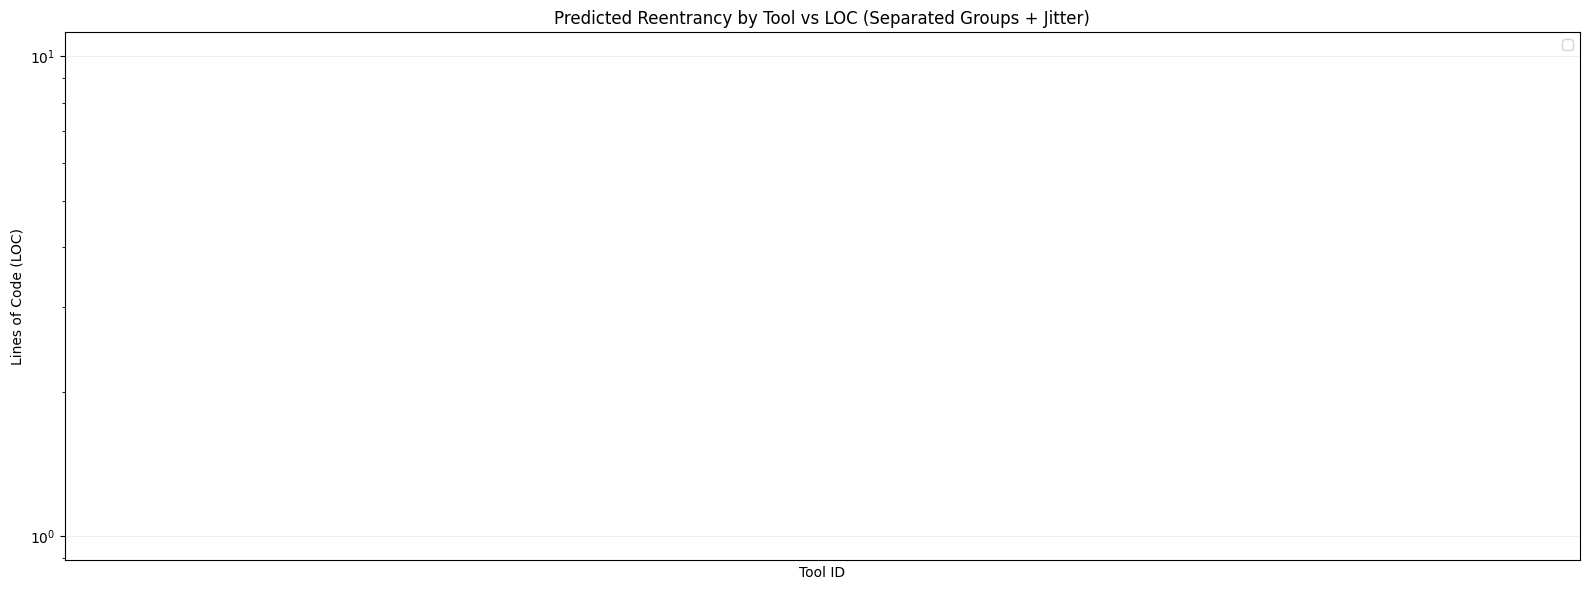

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# df_re must contain: toolid, loc, predicted_reentrancy

plt.figure(figsize=(16, 6))

tools = sorted(df_re["toolid"].unique())

# For each tool we create two x positions:
# left cluster  = predicted False
# right cluster = predicted True
x_base = {tool: i for i, tool in enumerate(tools)}

# width of separation between the two groups per tool
offset = 0.25

for tool in tools:
    subset = df_re[df_re["toolid"] == tool]
    base = x_base[tool]

    # FALSE group (orange)
    false_group = subset[subset["predicted_reentrancy"] == False]
    x_false = np.full(len(false_group), base - offset)
    x_false_jitter = x_false + np.random.normal(0, 0.05, size=len(false_group))

    plt.scatter(
        x_false_jitter,
        false_group["loc"],
        c="orange",
        s=20,
        alpha=0.7,
        label="Predicted False" if tool == tools[0] else None
    )

    # TRUE group (green)
    true_group = subset[subset["predicted_reentrancy"] == True]
    x_true = np.full(len(true_group), base + offset)
    x_true_jitter = x_true + np.random.normal(0, 0.05, size=len(true_group))

    plt.scatter(
        x_true_jitter,
        true_group["loc"],
        c="green",
        s=20,
        alpha=0.7,
        label="Predicted True" if tool == tools[0] else None
    )

# X-axis tick labels centered between groups
plt.xticks(range(len(tools)), tools)
plt.yscale("log")

plt.xlabel("Tool ID")
plt.ylabel("Lines of Code (LOC)")
plt.title("Predicted Reentrancy by Tool vs LOC (Separated Groups + Jitter)")
plt.legend()
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()


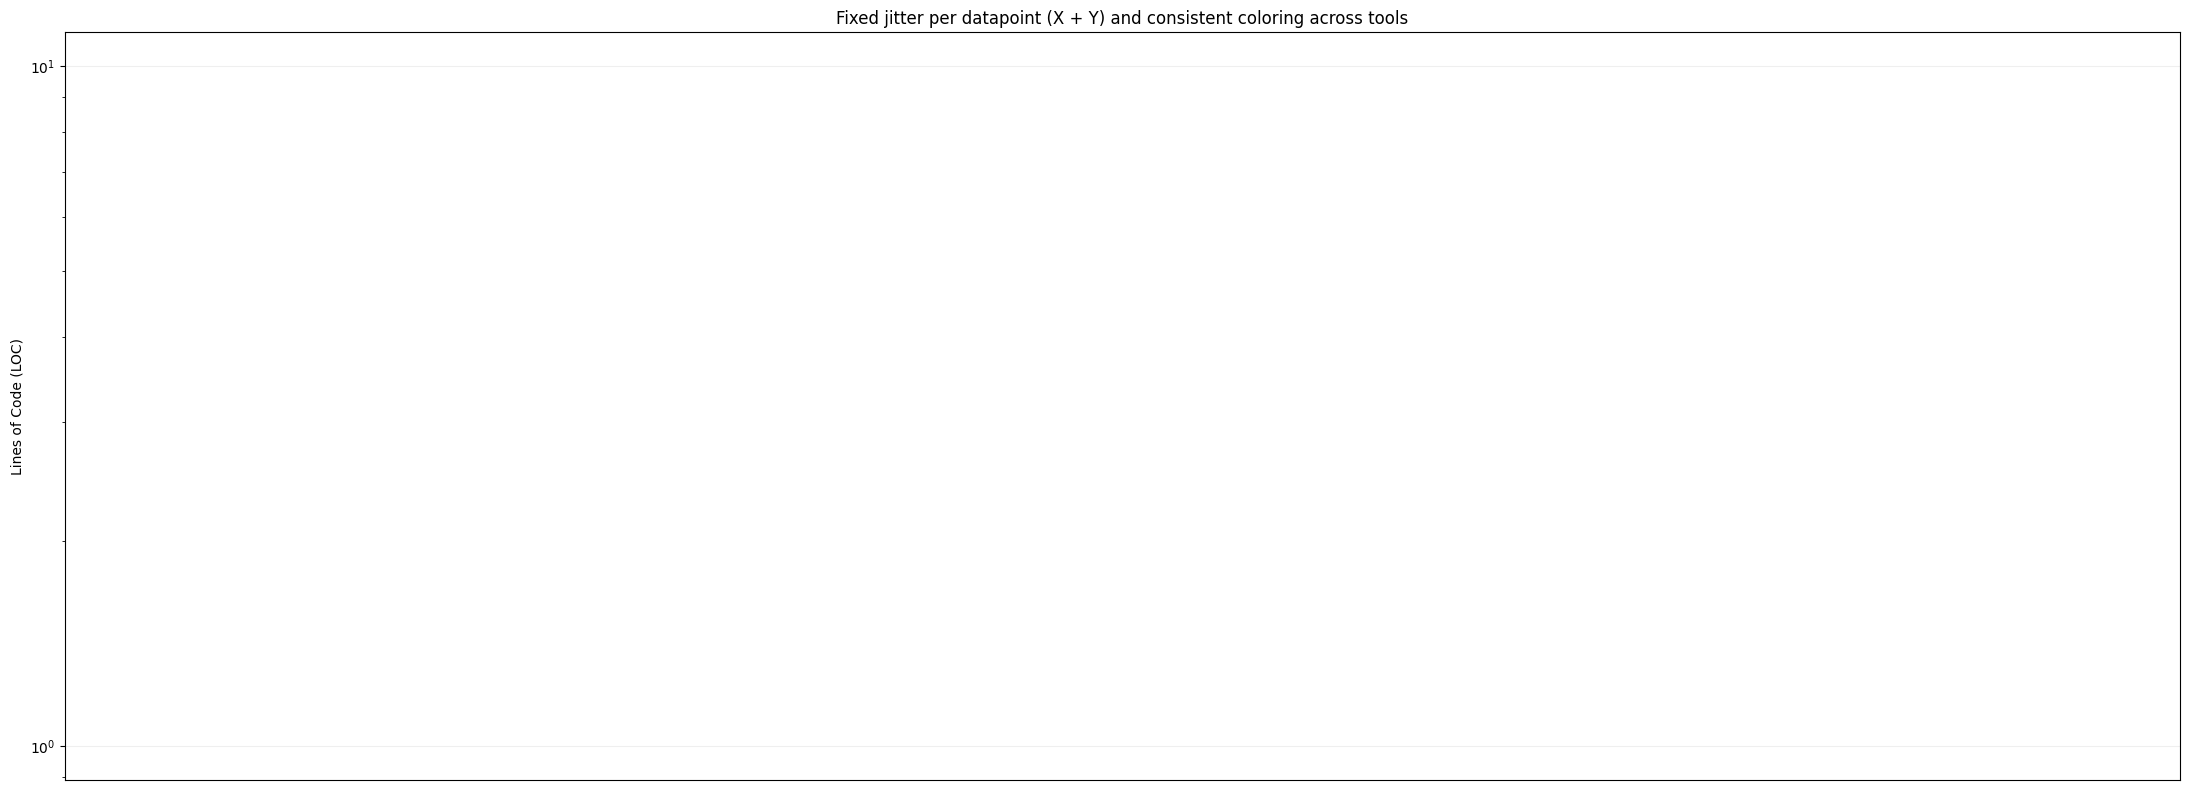

In [4]:
import matplotlib.pyplot as plt
import numpy as np

df = df_re.copy()

# ----------------------------------------------------
# 1. Assign UNIQUE COLOR + UNIQUE X-JITTER + UNIQUE Y-JITTER to each datapoint
# ----------------------------------------------------
unique_points = df["basename"].unique()
np.random.seed(42)

colors = {}
x_jitter = {}
y_jitter = {}

for name in unique_points:
    colors[name] = np.random.rand(3,)        # unique RGB color
    x_jitter[name] = np.random.normal(0, 0.1)  # FIXED X jitter
    y_jitter[name] = np.random.normal(0, 0.1)  # FIXED Y jitter

# ----------------------------------------------------
# 2. Build X-axis groups: tool_FALSE, tool_TRUE
# ----------------------------------------------------
tools = sorted(df["toolid"].unique())

x_labels = []
x_positions = {}
pos = 0

for tool in tools:
    x_positions[(tool, False)] = pos
    x_labels.append(f"{tool}\nFALSE")
    pos += 1
    
    x_positions[(tool, True)] = pos
    x_labels.append(f"{tool}\nTRUE")
    pos += 1

# ----------------------------------------------------
# 3. PLOT — fixed jitter X + fixed jitter Y
# ----------------------------------------------------
plt.figure(figsize=(22, 8))

for _, row in df.iterrows():
    name = row["basename"]
    tool = row["toolid"]
    loc = row["loc"]
    pred = row["predicted_reentrancy"]

    # FIXED jitter per datapoint
    x = x_positions[(tool, pred)] + x_jitter[name]
    y = loc * (1 + y_jitter[name])

    plt.scatter(
        x,
        y,
        c=[colors[name]],
        s=70,
        alpha=0.7,
        edgecolor="black",
        linewidth=0.4
    )

# ----------------------------------------------------
# 4. Formatting
# ----------------------------------------------------
plt.yscale("log")
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')
plt.ylabel("Lines of Code (LOC)")
plt.title("Fixed jitter per datapoint (X + Y) and consistent coloring across tools")

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators

# -------------------------------------------------------
# 1) Pivot booleano: righe = contratti, colonne = tool
# -------------------------------------------------------
pivot = df_re.pivot_table(
    index="basename",
    columns="toolid",
    values="predicted_reentrancy",
    aggfunc="first"
)

pivot = pivot.fillna(False)
pivot = pivot.astype(bool)

# -------------------------------------------------------
# 2) Convertiamo nel formato corretto per upsetplot
# -------------------------------------------------------
# ATTENZIONE: questa è la parte che mancava
upset_data = from_indicators(pivot)

# -------------------------------------------------------
# 3) Plot finale
# -------------------------------------------------------
plt.figure(figsize=(14, 10))

u = UpSet(
    upset_data,
    subset_size="count",
    sort_by="cardinality",
    show_counts=True
)

u.plot()

plt.suptitle("UpSet Plot – Predicted Reentrancy Across Tools", fontsize=16)
plt.show()


ModuleNotFoundError: No module named 'upsetplot'